<a href="https://colab.research.google.com/github/archyyu/GPT-from-MLP-to-RNN-to-Transformer/blob/main/GPT_by_RNN_with_attention_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
# Data I/O

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
#url = "https://raw.githubusercontent.com/archyyu/publicResource/main/google.dev.en"
#url = "https://raw.githubusercontent.com/torvalds/linux/master/mm/madvise.c"
response = requests.get(url)
data = response.text

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [3]:
# Hyperparameters
hidden_size = 100
embedding_dim = 20
seq_length = 25
learning_rate = 1e-1
batch_size = 20

In [8]:
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()
    self.attn = nn.Linear(hidden_size * 2, hidden_size)
    self.v = nn.Parameter(torch.rand(hidden_size))

  def forward(self, hidden, encoder_outputs):
    seq_len = encoder_outputs.size(1)
    hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
    energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=-1)))
    attention_scores = torch.matmul(energy, self.v)
    attention_weights = torch.softmax(attention_scores, dim=1)
    context_vector = torch.sum(attention_weights.unsqueeze(2) * encoder_outputs, dim=1)
    return context_vector

class ManillaRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(ManillaRNN, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.i2h = nn.Linear(embedding_dim, hidden_size, bias=False)
    self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)
    self.h2o = nn.Linear(hidden_size, vocab_size, bias=False)
    self.e2d = nn.Linear(hidden_size, vocab_size, bias=False)
    self.hb2 = nn.Parameter(torch.zeros(1, hidden_size))
    self.ob = nn.Parameter(torch.zeros(1, vocab_size))
    self.attention = Attention(hidden_size)

  def forward(self, x):
    h = torch.zeros(x.shape[0], self.hidden_size)
    y_list = []
    h_list = []
    h_list.append(h)
    for i in range(x.shape[1]):
      t = self.embedding(x[:,i])
      h = torch.tanh(self.i2h(t) + self.h2h(h) + self.hb2)
      h_list.append(h)
      cxt = self.attention(h, torch.stack(h_list, dim=1))
      y = self.e2d(cxt) + self.h2o(h) + self.ob
      y_list.append(y)
    return torch.stack(y_list, dim=1);


criterion = nn.CrossEntropyLoss()

model = ManillaRNN(vocab_size, embedding_dim, hidden_size)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

Now tusi ManillaRNN is different with the VanillaRNN.
It will iterate all the time step, drop the intermediate output, and only output the final one.

But I am not going to rewrite the training function to retrain the new model.
Because I think the VanillaRNN is more better and controlable than this one.


In [5]:
def getBatch():
  batch_inputs = []
  batch_targets = []

  start_idx = torch.randint(len(data) - seq_length - 2,[1]).item()

  # Generate examples for the current minibatch
  for i in range(batch_size):
    p = start_idx + i
    inputs = torch.tensor([char_to_ix[ch] for ch in data[p:p + seq_length]], dtype=torch.long).view(1, -1)
    targets = torch.tensor([char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]], dtype=torch.long).view(-1)

    batch_inputs.append(inputs)
    batch_targets.append(targets)

  # Convert lists to tensors
  minibatch_inputs = torch.cat(batch_inputs, dim=0)
  minibatch_targets = torch.stack(batch_targets)
  return minibatch_inputs, minibatch_targets

In [6]:
stopi = []
lossi = []

In [9]:
# Training loop
num_iterations = 10000
for iteration in range(num_iterations):

  inputs, targets = getBatch()
  predicts = model(inputs)
  optimizer.zero_grad()
  B,T = targets.shape

  totalloss = criterion(predicts.view(B*T, -1), targets.view(B*T))
  totalloss.backward()
  optimizer.step()

  if iteration % 1000 == 0:
    print(f'Iteration {iteration}, Loss: {totalloss}')
    stopi.append(iteration)
    lossi.append(totalloss.item())


Iteration 0, Loss: 4.233358860015869
Iteration 1000, Loss: 2.5893359184265137
Iteration 2000, Loss: 2.5119776725769043
Iteration 3000, Loss: 2.4074130058288574
Iteration 4000, Loss: 1.9933791160583496
Iteration 5000, Loss: 2.571129083633423
Iteration 6000, Loss: 2.278521776199341
Iteration 7000, Loss: 2.194293737411499
Iteration 8000, Loss: 1.8109192848205566
Iteration 9000, Loss: 2.155745506286621


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

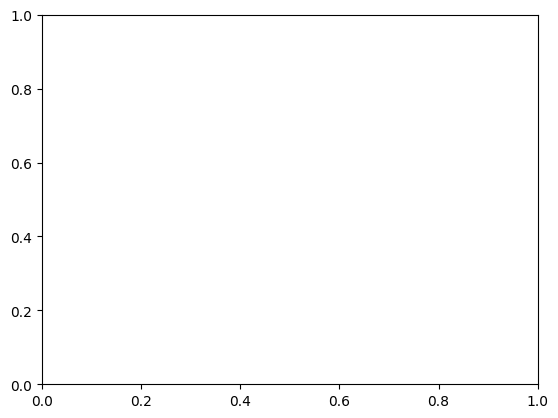

In [10]:
plt.plot(stopi, lossi)

In [11]:
with torch.no_grad():

  start = ['F','i','r','s','t']
  result = ['F','i','r','s','t']

  for i in range(1000):
    start = start[-seq_length:]
    ilist = torch.tensor([char_to_ix[i] for i in start])
    ilist = ilist.reshape(1, -1)
    outputs = model(ilist)

    p = nn.functional.softmax(outputs[:,-1,:], dim=-1).detach().numpy().ravel()
    ix = np.random.choice(range(vocab_size), p=p)
    start.append(ix_to_char[ix])
    result.append(ix_to_char[ix])

  print(''.join(result))

Firstare have detlesh, goce.

KENAR:
Where som, tury of thee tithor agrech timespichifnelle to heaven Pitshas be then to me ablent; herant, the are no thinough this dearet
Idire conead'd thought!.

QUREL RO:
Kf worldy wall hete,
Which I coive that apathory
Benret the surte then aon to been.
For yourter you bepsistifore,

ANGEA, My is cay, hath thising the mienciry thulcons siest
It cone he that the'd larril've-wour thou imfall knide,
For my conleliin their get-bitife nall tisuldeer, a conbrand, If eroeape: in besmides;
But may.h regrye ubred tighin soal detittast!
Madse, for as your to samfont, stule.
Gay,
Be on umbroors unarsed; salily pappiom I britand fornay a feey bemiun, as wllewurser sentepuse
To the sun me tellows yartion.

ESCALUS:
Sercasate uncioufe
Te Anded the nest I thimow lord: that my do
wer, his Mare crown, comt ot this her pet.
Gemped ho, for, do med the antue Culian condy:
And Whatizeres was, EXENTEL:
Whath of enorieve, thy pray hored
anfuer;
Whis it say, are hast of t

The new idea is that.

I always use the last time step as the final output of the RNN, or as the predict character of the previous input. we could go further as that, add attention in the final step, to focus differently on the previous tokens to decide what to predict, let do that.

finnally, I add attention to every time step, to focus differently on the previouse tokens

let see the results.